In [227]:
from sklearn.cluster import OPTICS
from sklearn.manifold import Isomap
import numpy as np
from google.cloud import storage
from google.cloud.storage import Blob
from numpy import genfromtxt
import os
import pandas as pd
from utils import model_and_evaluate_cluster as ev
import itertools
import time
from os.path import exists

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
import plotly
import plotly.express as px

In [120]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])
        
        
def load_model(df):
    home = '/home/jupyter/pss/'

    model = df
    model.query_protein = 'AF-' + model.query_protein.astype(str) + '-F1-model_v1'
    model.target_protein = 'AF-' + model.target_protein.astype(str) + '-F1-model_v1'
    
    batch_stats = pd.read_parquet('pairwise_evaluation_metrics.parquet')
    
    batch_stats.set_index(['query_protein', 'target_protein'], inplace=True)
    model.set_index(['query_protein', 'target_protein'], inplace=True)
    model_stats = model.join(batch_stats, on=['query_protein', 'target_protein'], how='left')
    
    return model_stats.reset_index()


pd.options.display.max_colwidth = 100
deepfold_nomask = [f'embeddings/DeepFold/withMask=false/embeddings_0{n}.csv' for n in range(0,10)]
deepfold_nomask.extend([f'embeddings/DeepFold/withMask=false/embeddings_{n}.csv' for n in range(10,21)])
print('DeepFold (no mask):')
print(pd.DataFrame(deepfold_nomask))

deepfold_mask = [f'embeddings/DeepFold/withMask=true/deepfold_0{n}.csv' for n in range(0,10)]
deepfold_mask.extend([f'embeddings/DeepFold/withMask=true/deepfold_{n}.csv' for n in range(10,24)])
print('\nDeepFold (mask):')
print(pd.DataFrame(deepfold_mask))

DeepFold (no mask):
                                                       0
0   embeddings/DeepFold/withMask=false/embeddings_00.csv
1   embeddings/DeepFold/withMask=false/embeddings_01.csv
2   embeddings/DeepFold/withMask=false/embeddings_02.csv
3   embeddings/DeepFold/withMask=false/embeddings_03.csv
4   embeddings/DeepFold/withMask=false/embeddings_04.csv
5   embeddings/DeepFold/withMask=false/embeddings_05.csv
6   embeddings/DeepFold/withMask=false/embeddings_06.csv
7   embeddings/DeepFold/withMask=false/embeddings_07.csv
8   embeddings/DeepFold/withMask=false/embeddings_08.csv
9   embeddings/DeepFold/withMask=false/embeddings_09.csv
10  embeddings/DeepFold/withMask=false/embeddings_10.csv
11  embeddings/DeepFold/withMask=false/embeddings_11.csv
12  embeddings/DeepFold/withMask=false/embeddings_12.csv
13  embeddings/DeepFold/withMask=false/embeddings_13.csv
14  embeddings/DeepFold/withMask=false/embeddings_14.csv
15  embeddings/DeepFold/withMask=false/embeddings_15.csv
16  embeddi

# Modeling

In [206]:
# DEEPFOLD EMBEDDINGS

X, y, p = [], [], []

for file in deepfold_nomask:
    tX, ty, tp = ev.deepfold_file_processor(file)
    X.extend(tX)
    y.extend(ty)
    p.extend(tp)
    
print(len(X), len(y), len(p))

20301 20301 203


In [116]:
# SEQVEC EMBEDDINGS

import pickle5 as pickle

download_file('embeddings/SeqVec/seqvec_vectors.pkl')

with open('seqvec_vectors.pkl', 'rb') as f:
    tmp = pickle.load(f)

X = tmp.seqvec.tolist()
y = tmp.protein_id.tolist()

print(len(X), len(y))

20504 20504


In [207]:
# OPTIONAL - Eliminate Low AlphaFold Prediction Confidence Proteins
download_file('structure_files/sequences/sequences.parquet')
low_bois = pd.read_parquet('sequences.parquet')
low_bois = low_bois[low_bois.confidence_pLDDT < 50.]['protein_id'].values
tmpX = []
tmpy = []
for i, p in enumerate(X):
    if y[i] not in low_bois:
        tmpX.append(p)
        tmpy.append(y[i])
X = tmpX
y = tmpy
print(len(X), len(y))

19320 19320


In [ ]:
# SINGLE PARAMETER SET TEST

import random

run = 'DeepFold-Masked-ExclLowConf_OPTICS_gridsearch'

start = time.time()
clustering = OPTICS(min_samples=3,
                    metric='cosine'
                   ).fit(X)

print(f"Took {int((time.time() - start) / 60)} minutes.")

num_proteins = len(clustering.labels_)
num_noise = len(clustering.labels_[clustering.labels_ == -1])

dl = pd.DataFrame(clustering.labels_, columns=['label'])
dl['protein'] = y
dl.to_parquet(run + '_cosine_3_labels.parquet')

print(f'Proteins: {num_proteins:,.0f}')
print(f' - Noise: {num_noise:,.0f} ({round(num_noise / num_proteins, 4)})')
print(f' - Clusters: {len(set(clustering.labels_))-1:,.0f}')

In [ ]:
c = pd.DataFrame(clustering.labels_, columns=['l'])
c[c.l != -1].hist(bins=len(c[c.l != -1].l.unique()), figsize=(10,8));

In [208]:
def store_result(run_name, res):
    filename = run_name + '.parquet'
    t = pd.DataFrame(None, columns=['metric', 'min_samples', 'proteins', 'runtime', 'noise', 'clusters_no_noise', 'silhouette_no_noise', 'cluster_sizes_no_noise'])
    for j, i in enumerate(range(0, len(res), 7)):
        t.loc[j] = [res[i][0], res[i][1], res[i+1], res[i+2], res[i+3], len(res[i+4])-1, res[i+5][1], res[i+6]]
    t.to_parquet(filename)

In [211]:
# GRIDSEARCH

from IPython.display import clear_output

grid = {'min_samples': [3, 4],
        'metric': ['cosine']}
track = [0, len(grid['metric']) * len(grid['min_samples'])]

res = []
run = 'DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_cosine'

for metric in grid['metric']:
    for sample in grid['min_samples']:
        track[0] += 1
        clear_output()
        print(track)
        
        res.append((metric, sample))
        res.append(len(X))
        clustering = OPTICS(metric=metric, min_samples=sample, n_jobs=os.cpu_count() - 1)
        
        start = time.time()
        clustering.fit(X)
        
        res.append(int((time.time() - start) / 60))
        
        cluster_labels = clustering.labels_
        pd.DataFrame(cluster_labels, columns=['label']).to_parquet(run + '_' + metric + '_' + str(sample) + '_labels.parquet')
        unique_labels = list(set(cluster_labels))
        
        x = pd.DataFrame(clustering.labels_, columns=['l'])
        x['i'] = 1
        x = x[x.l != -1].groupby(['l']).sum().reset_index().sort_values(by=['i'], ascending=False)['i'].values
        
        res.append(len(cluster_labels[cluster_labels == -1]))
        res.append(unique_labels)
        
        # silhouette requires len(unique_labels) > 2, but also we shouldn't bother if the model produces 100 or fewer clusters
        # why 100? arbitrary, but feels like a sure invalid result based on prior experiments
        if len(unique_labels) > 100:
            non_noise = np.array(X)[cluster_labels != -1]
            res.append(ev.silhouette_n_davies(non_noise, cluster_labels[cluster_labels != -1]))
            res.append(x)
            store_result(run, res)
        else:
            res.append((None, None))
            res.append(x)
            store_result(run, res)
            # stop gridsearch if the model starts producing 100 or fewer clusters
            track[1] -= 1
            break

[2, 2]


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [212]:
def preview_results():
    experiments = ['DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_cosine']

    gs_results = pd.DataFrame(None, columns = ['metric', 'min_samples', 'proteins', 'runtime', 'noise', 'clusters_no_noise', 'silhouette_no_noise', 'cluster_sizes_no_noise', 'experiment', 'noise_ratio'])
    for exp in experiments:
        t = pd.read_parquet(exp + '.parquet')
        t['experiment'] = exp
        t['noise_ratio'] = round(t.noise / t.proteins, 2)
        gs_results = gs_results.append(t)

    return gs_results.sort_values(by=['clusters_no_noise', 'silhouette_no_noise'], ascending=False)

preview_results()

metric min_samples proteins runtime  noise clusters_no_noise  \
0  cosine           3    19320      53  13817              1246   
1  cosine           4    19320      53  15496               600   

   silhouette_no_noise  \
0             0.932971   
1             0.892993   

                                                                                cluster_sizes_no_noise  \
0  [17, 16, 16, 15, 15, 15, 14, 14, 13, 13, 13, 13, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,...   
1  [28, 20, 20, 19, 19, 18, 18, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14,...   

                                             experiment  noise_ratio  
0  DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_cosine         0.72  
1  DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_cosine         0.80

In [215]:
embedding = Isomap(n_components=3, metric='cosine')
X_transformed = embedding.fit_transform(X)
data = pd.DataFrame(X_transformed, columns = ['X', 'Y', 'Z'])
data['cluster'] = clustering.labels_
data['protein'] = y

In [216]:
data = data[data.cluster != -1]

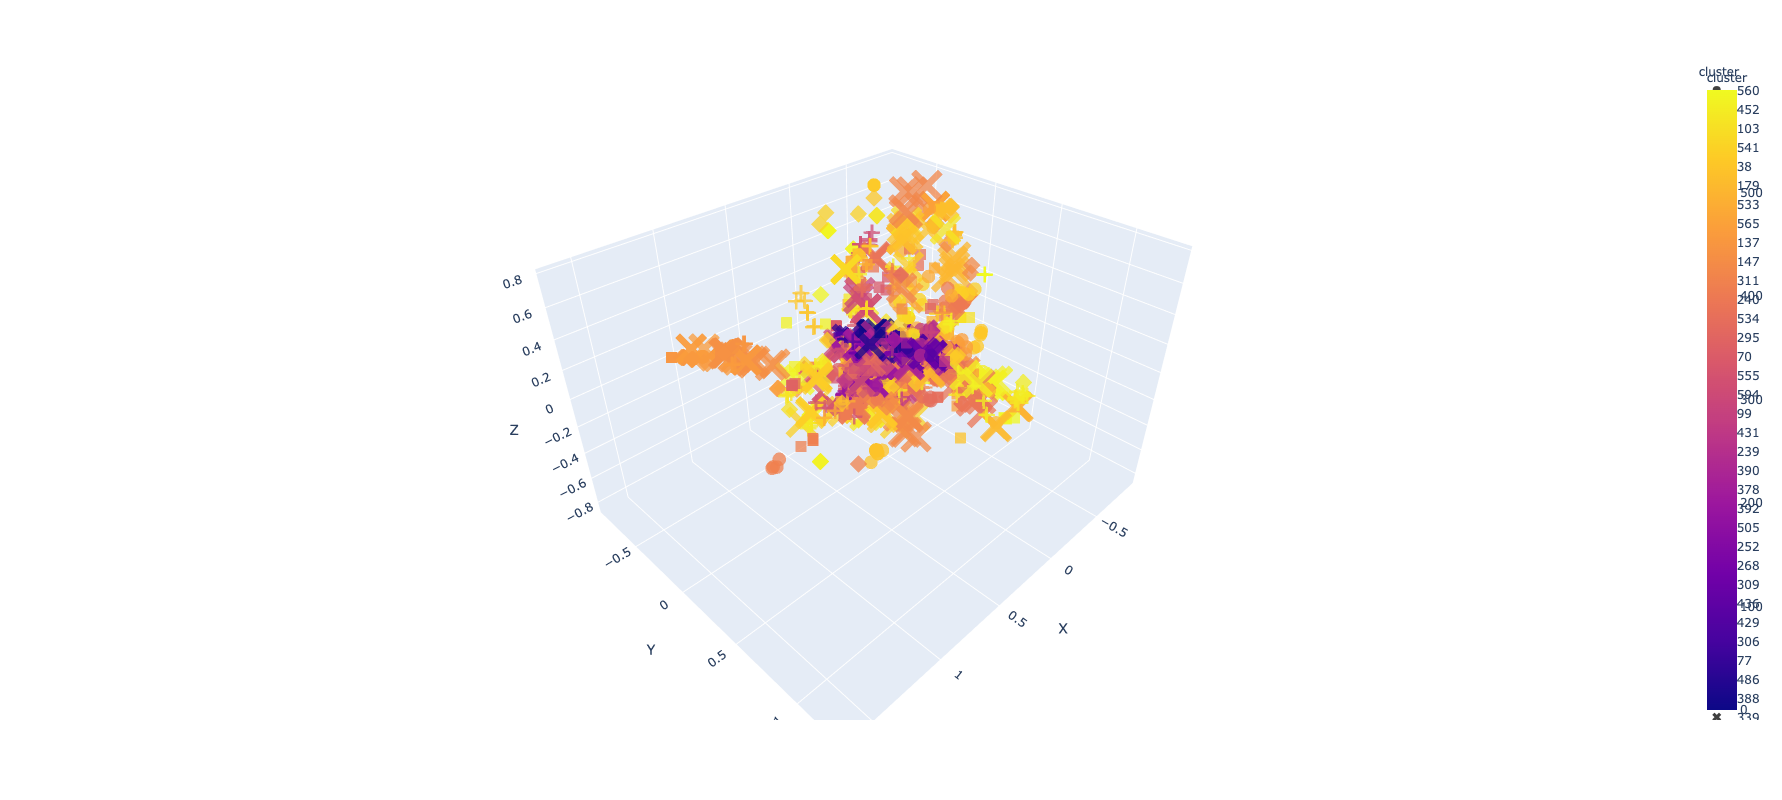

In [217]:
fig = px.scatter_3d(data.sample(2000), x='X', y='Y', z='Z', 
                    color='cluster', width=1000, 
                    height=800, opacity=0.75, 
                    hover_data=['cluster', 'protein'], symbol='cluster')
fig.show()

# Analysis

26118


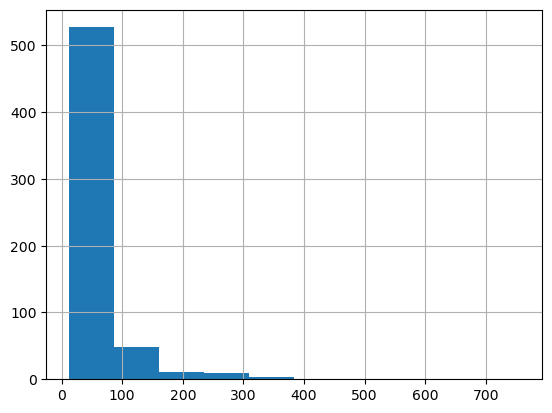

In [218]:
# Find all combinations of proteins WITHIN clusters
all_combos = pd.DataFrame()

for clust in list(set(clustering.labels_[clustering.labels_ != -1])):
    clust_combos = pd.DataFrame(itertools.product(data[data.cluster == clust].protein, repeat=2), columns=['query_protein', 'target_protein'])
    clust_combos = clust_combos[clust_combos.query_protein != clust_combos.target_protein]
    clust_combos['cluster'] = clust
    all_combos = all_combos.append(clust_combos)

print(len(all_combos))
all_combos[['cluster', 'query_protein']].groupby(['cluster']).count().reset_index().query_protein.hist();

In [219]:
stats = load_model(all_combos)
stats

query_protein         target_protein  cluster  \
0      AF-Q5RL73-F1-model_v1  AF-Q9H1X3-F1-model_v1        0   
1      AF-Q5RL73-F1-model_v1  AF-O95807-F1-model_v1        0   
2      AF-Q5RL73-F1-model_v1  AF-P59773-F1-model_v1        0   
3      AF-Q5RL73-F1-model_v1  AF-Q6UX52-F1-model_v1        0   
4      AF-Q9H1X3-F1-model_v1  AF-Q5RL73-F1-model_v1        0   
...                      ...                    ...      ...   
26113  AF-Q9H5V9-F1-model_v1  AF-P07741-F1-model_v1      599   
26114  AF-Q9H5V9-F1-model_v1  AF-P33076-F1-model_v1      599   
26115  AF-Q9H5V9-F1-model_v1  AF-Q9NXC2-F1-model_v1      599   
26116  AF-Q9H5V9-F1-model_v1  AF-P17405-F1-model_v1      599   
26117  AF-Q9H5V9-F1-model_v1  AF-Q8IV08-F1-model_v1      599   

       query_protein_length  target_protein_length  aligned_length  rmsd  \
0                     367.0                  360.0           107.0  6.10   
1                     367.0                  157.0            71.0  5.43   
2                     367.0                  190.0            82.0  4.48   
3                     367.0                  265.0           110.0  6.71   
4                     360.0                  367.0           107.0  6.10   
...                     ...                    ...             ...   ...   
26113                 222.0                  180.0            80.0  6.00   
26114                 222.0                 1130.0           131.0  5.70   
26115                 222.0                  390.0            82.0  5.67   
26116                 222.0                  631.0            96.0  6.08   
26117                 222.0                  490.0           104.0  5.95   

       tmalign_score  
0            0.19105  
1            0.13787  
2            0.17240  
3            0.18360  
4            0.19387  
...              ...  
26113        0.20204  
26114        0.34644  
26115        0.21865  
26116        0.24542  
26117        0.27063  

[26118 rows x 8 columns]

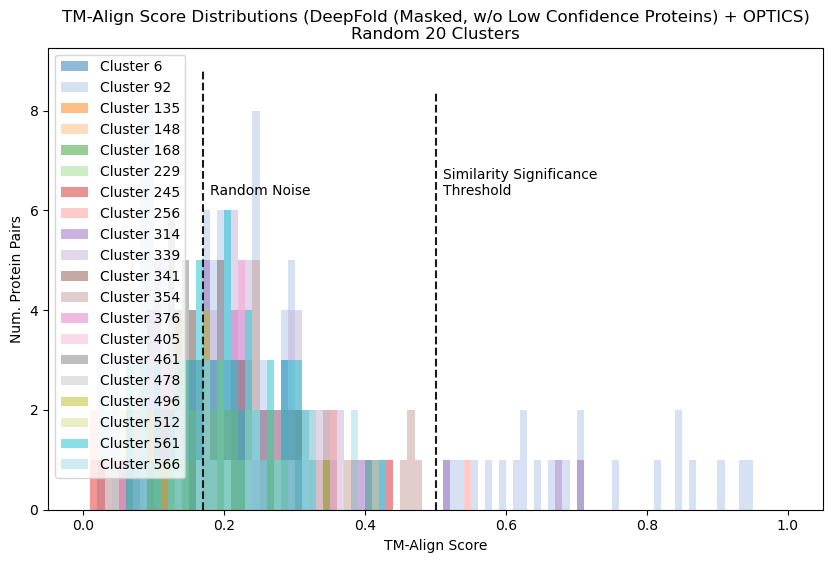

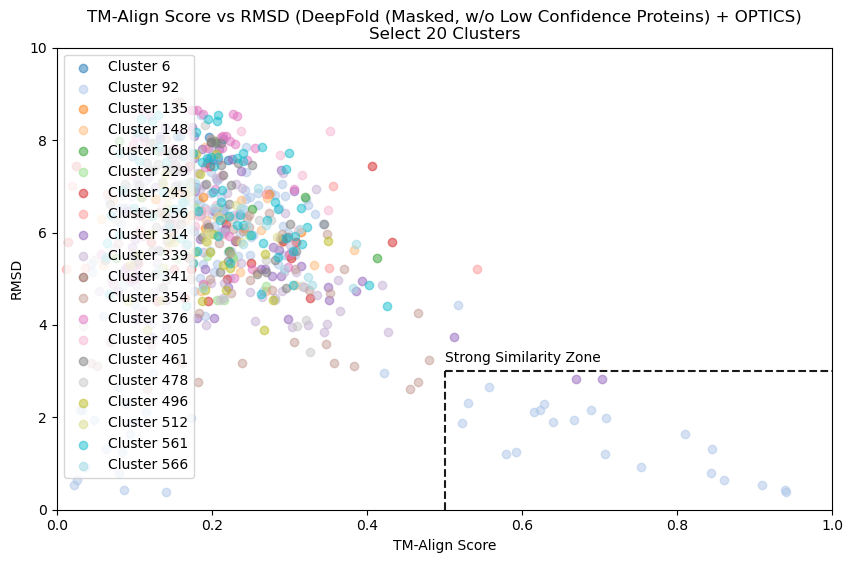

In [220]:
cmap = 'tab20'
name = 'DeepFold (Masked, w/o Low Confidence Proteins) + OPTICS'

plot_1_clusters = ev.tmalign_hist(stats, version='random', num_results=20, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(stats[stats.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [221]:
blast = pd.read_parquet('blast_annotations_agg.parquet')
blast.set_index(['query_protein', 'target_protein'], inplace=True)
stats_expanded = stats.set_index(['query_protein', 'target_protein']).join(blast, on=['query_protein', 'target_protein'], how='left')
stats_expanded

cluster  query_protein_length  \
query_protein         target_protein                                         
AF-Q5RL73-F1-model_v1 AF-Q9H1X3-F1-model_v1        0                 367.0   
                      AF-O95807-F1-model_v1        0                 367.0   
                      AF-P59773-F1-model_v1        0                 367.0   
                      AF-Q6UX52-F1-model_v1        0                 367.0   
AF-Q9H1X3-F1-model_v1 AF-Q5RL73-F1-model_v1        0                 360.0   
...                                              ...                   ...   
AF-Q9H5V9-F1-model_v1 AF-P07741-F1-model_v1      599                 222.0   
                      AF-P33076-F1-model_v1      599                 222.0   
                      AF-Q9NXC2-F1-model_v1      599                 222.0   
                      AF-P17405-F1-model_v1      599                 222.0   
                      AF-Q8IV08-F1-model_v1      599                 222.0   

                                             target_protein_length  \
query_protein         target_protein                                 
AF-Q5RL73-F1-model_v1 AF-Q9H1X3-F1-model_v1                  360.0   
                      AF-O95807-F1-model_v1                  157.0   
                      AF-P59773-F1-model_v1                  190.0   
                      AF-Q6UX52-F1-model_v1                  265.0   
AF-Q9H1X3-F1-model_v1 AF-Q5RL73-F1-model_v1                  367.0   
...                                                            ...   
AF-Q9H5V9-F1-model_v1 AF-P07741-F1-model_v1                  180.0   
                      AF-P33076-F1-model_v1                 1130.0   
                      AF-Q9NXC2-F1-model_v1                  390.0   
                      AF-P17405-F1-model_v1                  631.0   
                      AF-Q8IV08-F1-model_v1                  490.0   

                                             aligned_length  rmsd  \
query_protein         target_protein                                
AF-Q5RL73-F1-model_v1 AF-Q9H1X3-F1-model_v1           107.0  6.10   
                      AF-O95807-F1-model_v1            71.0  5.43   
                      AF-P59773-F1-model_v1            82.0  4.48   
                      AF-Q6UX52-F1-model_v1           110.0  6.71   
AF-Q9H1X3-F1-model_v1 AF-Q5RL73-F1-model_v1           107.0  6.10   
...                                                     ...   ...   
AF-Q9H5V9-F1-model_v1 AF-P07741-F1-model_v1            80.0  6.00   
                      AF-P33076-F1-model_v1           131.0  5.70   
                      AF-Q9NXC2-F1-model_v1            82.0  5.67   
                      AF-P17405-F1-model_v1            96.0  6.08   
                      AF-Q8IV08-F1-model_v1           104.0  5.95   

                                             tmalign_score  hit_span_mean  \
query_protein         target_protein                                        
AF-Q5RL73-F1-model_v1 AF-Q9H1X3-F1-model_v1        0.19105            NaN   
                      AF-O95807-F1-model_v1        0.13787            NaN   
                      AF-P59773-F1-model_v1        0.17240            NaN   
                      AF-Q6UX52-F1-model_v1        0.18360            NaN   
AF-Q9H1X3-F1-model_v1 AF-Q5RL73-F1-model_v1        0.19387            NaN   
...                                                    ...            ...   
AF-Q9H5V9-F1-model_v1 AF-P07741-F1-model_v1        0.20204            NaN   
                      AF-P33076-F1-model_v1        0.34644            NaN   
                      AF-Q9NXC2-F1-model_v1        0.21865            NaN   
                      AF-P17405-F1-model_v1        0.24542            NaN   
                      AF-Q8IV08-F1-model_v1        0.27063            NaN   

                                             bitscore_mean  evalue_mean  
query_protein         target_protein                                     
AF-Q5RL73-F1-model_v1 AF-Q9H1X3-F1-model_v1            NaN          NaN

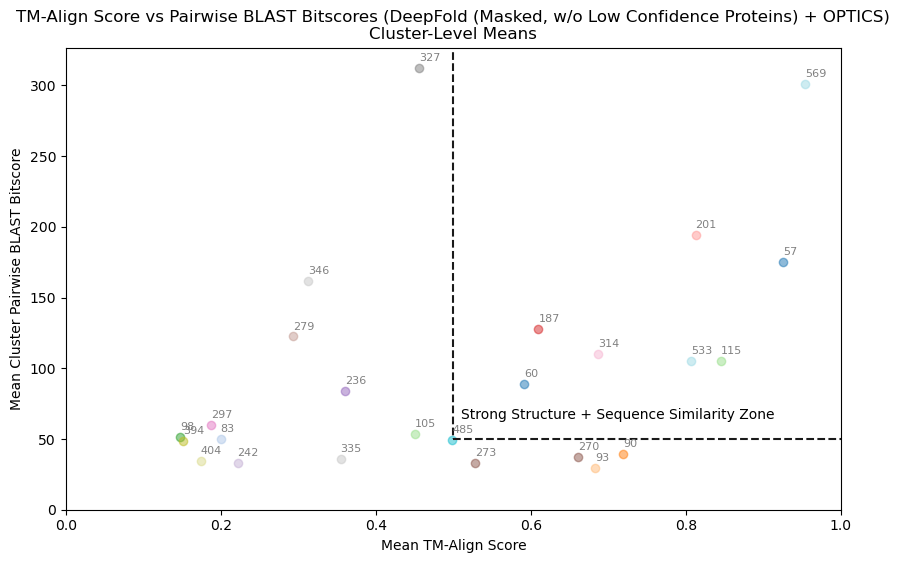

In [223]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

t = stats_expanded[~stats_expanded.rmsd.isna() & ~stats_expanded.bitscore_mean.isna()][['cluster', 'tmalign_score', 'bitscore_mean']].groupby(['cluster']).mean().reset_index()
t = t[t.cluster.isin(t.cluster.sample(25))]

cmap='tab20'
figure(figsize=(10, 6))
pyplot.style.use('default')
colors = pyplot.get_cmap(cmap, len(t))

for i, cluster in enumerate(t.values):
    pyplot.scatter(x=cluster[1], y=cluster[2], alpha=0.5, color=colors(i), label=f'Cluster {int(cluster[0])}')
    pyplot.annotate(int(cluster[0]), # this is the text
                 (cluster[1],cluster[2]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='left',
                   fontsize=8., color='grey') # horizontal alignment can be left, right or center
#pyplot.legend(loc='upper left')

pyplot.xlim(left=0, right=1)
pyplot.ylim(bottom=0)
pyplot.vlines(0.5, t.bitscore_mean.max() +50, 50, linestyles='dashed', colors='k')
pyplot.hlines(50, 0.5, 1, linestyles='dashed', colors='k')
pyplot.text(0.51, 64, 'Strong Structure + Sequence Similarity Zone')
pyplot.xlabel('Mean TM-Align Score')
pyplot.ylabel('Mean Cluster Pairwise BLAST Bitscore')
pyplot.title(f'TM-Align Score vs Pairwise BLAST Bitscores ({name})\nCluster-Level Means')
pyplot.show();

In [224]:
t = stats_expanded[~stats_expanded.rmsd.isna() & ~stats_expanded.bitscore_mean.isna()][['cluster', 'tmalign_score', 'bitscore_mean', 'rmsd']].groupby(['cluster']).mean().reset_index()
z = t[t.bitscore_mean > 50]
z = z[z.tmalign_score > 0.5]
z = z[z.rmsd < 3.]
print(name.upper())
print(f'Percent clusters in S4 Zone intersect S2 Zone:', round(len(z) / len(t), 4))
tmp = stats_expanded[~stats_expanded.rmsd.isna() & ~stats_expanded.bitscore_mean.isna()]
print(f'Percent protein pairs in S4 Zone intersect S2 Zone:', round(len(tmp[tmp.cluster.isin(z.cluster.unique())]) / len(tmp), 4))
print('Noise Ratio:', round(len(stats_expanded[stats_expanded.cluster == -1]) / len(stats_expanded[~stats_expanded.tmalign_score.isna()]), 4), '(should be 0; noise pre-trimmed)')
print('TM-Align score coverage:', round(len(stats_expanded[~stats_expanded.rmsd.isna()]) / len(stats_expanded), 4))

DEEPFOLD (MASKED, W/O LOW CONFIDENCE PROTEINS) + OPTICS
Percent clusters in S4 Zone intersect S2 Zone: 0.2444
Percent protein pairs in S4 Zone intersect S2 Zone: 0.25
Noise Ratio: 0.0 (should be 0; noise pre-trimmed)
TM-Align score coverage: 0.9301


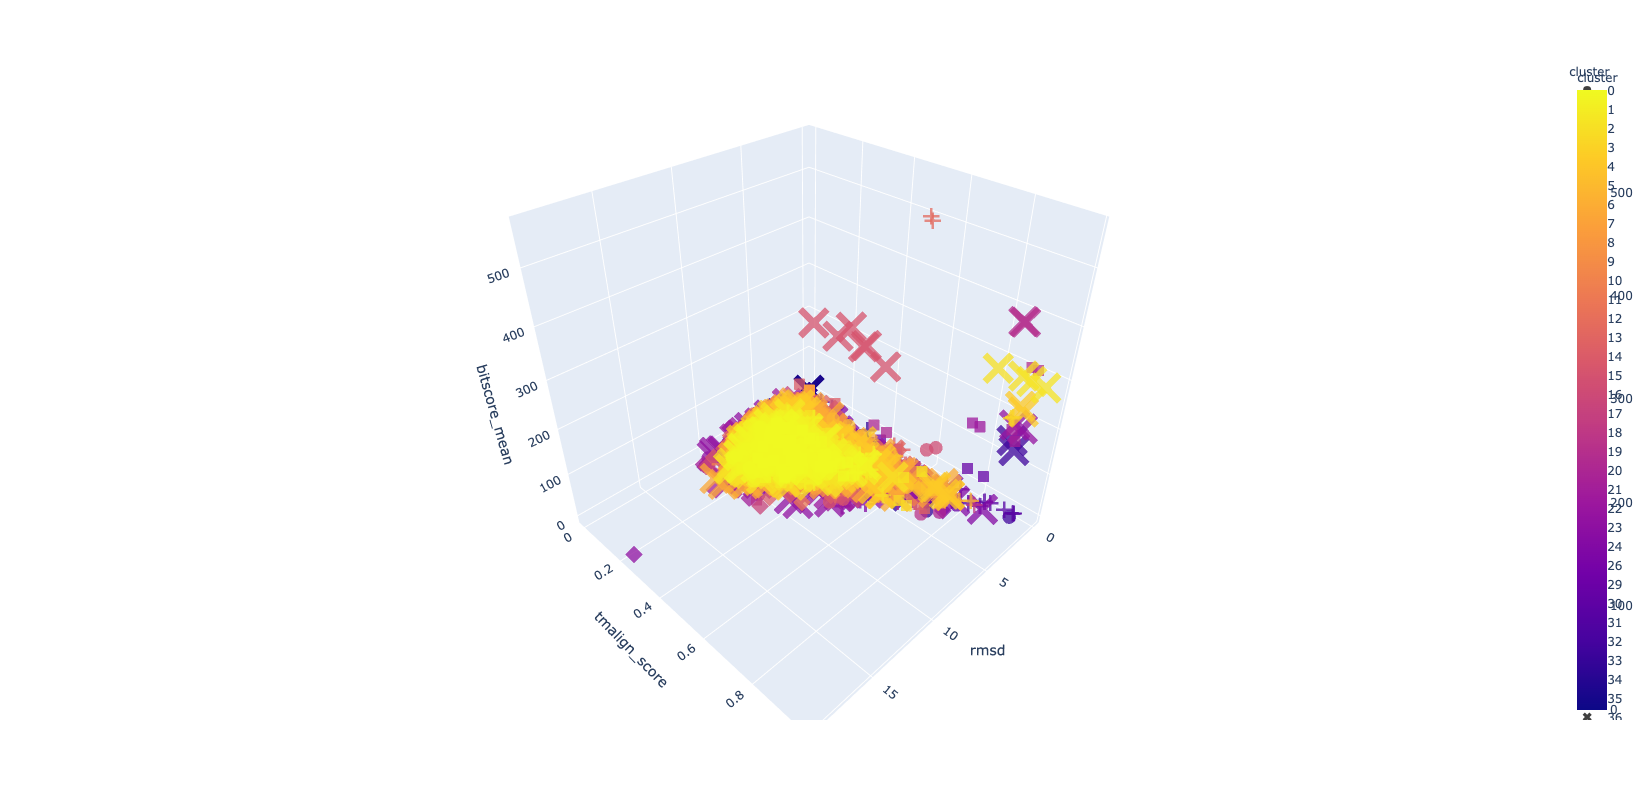

In [226]:
fig = px.scatter_3d(stats_expanded[~stats_expanded.rmsd.isna()].reset_index().fillna(0), x='rmsd', y='tmalign_score', z='bitscore_mean', 
                    color='cluster', width=1000, 
                    height=800, opacity=0.75, 
                    hover_data=['cluster', 'target_protein', 'query_protein'], symbol='cluster')
fig.show()

In [149]:
all_combos.reset_index().to_parquet('C1-OPTICS-DeepFold-Mask-NoLowConf-all_protein_combos_per_cluster.parquet')

In [150]:
import pickle
filehandler = open("C1_model_mask_nolowconf.pkl","wb")
pickle.dump(clustering, filehandler)

In [225]:
import numpy as np
from sklearn import metrics

mask = clustering.labels_ != -1
print('Silhouette WITH Noise:', metrics.silhouette_score(X, clustering.labels_, metric='cosine'))
print('Silhouette WITHOUT Noise:', metrics.silhouette_score(np.array(X)[mask], clustering.labels_[mask], metric='cosine'))

Silhouette WITH Noise: -0.4458279162998949
Silhouette WITHOUT Noise: 0.6141137885583742


# ID & Eliminate Low Confidence Proteins

989